In [3]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

In [4]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

In [5]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

In [7]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    x = self._model(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

In [8]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

In [10]:
epochs = 100
learning_rate = 0.4

In [11]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [12]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

In [13]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0005 using 16 parameters.
DeepNet(large) RMSE is 0.0211 using 166401 parameters.


C:\Users\AI-INNOVATOR\AppData\Local\Temp\ipykernel_10916\2879280353.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
C:\Users\AI-INNOVATOR\AppData\Local\Temp\ipykernel_10916\2879280353.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([''] + features, fontsize=10)


<Figure size 648x648 with 0 Axes>

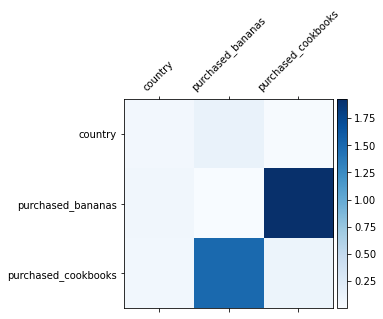

In [14]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)